In [20]:
# assessment data:
# https://www.eea.europa.eu/publications/status-of-air-quality-in-Europe-2022/europes-air-quality-status-2022/world-health-organization-who-air
# https://powietrze.gios.gov.pl/pjp/content/annual_assessment_air_acceptable_level

# *data:
# https://powietrze.gios.gov.pl/pjp/current/station_details/archive/402
# for October 2023 Krakow - ul. Bulwarowa
# * in exported csv, CO values are in mg/m3 not ug/m3

In [21]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [22]:
pm10_safe_limit = 50 # 24h -> ug/m3
pm25_safe_limit = 25 # 24h -> ug/m3
no2_safe_limit = 200 # 24h -> ug/m3
so2_safe_limit = 350 # 24h -> ug/m3
co_safe_limit = 8 # 24h -> mg/m3

In [23]:
# create df
column_names = ["Date Time", "PM10", "PM25", "NO2", "SO2", "CO"]
df = pd.read_csv("gios-pjp-data.csv", sep=",", skiprows=1, header=None)
df = df.iloc[:, :-1]
df.columns = column_names
df[column_names[1:]] = df[column_names[1:]].replace(r"^\s*$", np.nan, regex=True)
df = df.dropna()
df["Date Time"] = pd.to_datetime(df["Date Time"], format="%Y-%m-%d %H:%M")
df["PM10"] = df["PM10"].astype(float)
df["PM25"] = df["PM25"].astype(float)
df["NO2"] = df["NO2"].astype(float)
df["SO2"] = df["SO2"].astype(float)
df["CO"] = df["CO"].astype(float)

In [24]:
df.head()

,Date Time,PM10,PM25,NO2,SO2,CO
0,2023-10-01 01:00:00,18.9,25.8,16.3,2.1,0.2
1,2023-10-01 02:00:00,18.9,25.2,15.7,1.2,0.2
5,2023-10-01 06:00:00,23.3,28.9,20.4,2.8,0.2
6,2023-10-01 07:00:00,20.0,26.1,18.1,2.0,0.2
7,2023-10-01 08:00:00,16.5,21.1,13.9,2.0,0.2


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 729 entries, 0 to 743
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date Time  729 non-null    datetime64[ns]
 1   PM10       729 non-null    float64       
 2   PM25       729 non-null    float64       
 3   NO2        729 non-null    float64       
 4   SO2        729 non-null    float64       
 5   CO         729 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 39.9 KB


In [26]:
df.describe()

,Date Time,PM10,PM25,NO2,SO2,CO
count,729,729.000000,729.000000,729.000000,729.000000,729.000000
mean,2023-10-16 13:10:07.407407104,18.941975,27.338134,20.982716,3.391770,0.269410
min,2023-10-01 01:00:00,2.200000,3.100000,3.900000,0.000000,0.000000
25%,2023-10-08 21:00:00,9.700000,14.900000,13.200000,2.500000,0.100000
50%,2023-10-16 14:00:00,16.600000,22.700000,19.300000,3.200000,0.200000
75%,2023-10-24 07:00:00,24.000000,35.200000,26.800000,3.900000,0.400000
max,2023-11-01 00:00:00,74.600000,270.900000,56.200000,19.200000,1.000000
std,NaN,11.894110,19.358087,10.243449,1.629683,0.179926


In [27]:
pm10_max = df["PM10"].max() if df["PM10"].max() > pm10_safe_limit else pm10_safe_limit
pm25_max = df["PM25"].max() if df["PM25"].max() > pm25_safe_limit else pm25_safe_limit
no2_max = df["NO2"].max() if df["NO2"].max() > no2_safe_limit else no2_safe_limit
so2_max = df["SO2"].max() if df["SO2"].max() > so2_safe_limit else so2_safe_limit
co_max = df["CO"].max() if df["CO"].max() > co_safe_limit else co_safe_limit

In [28]:
step_size = 0.01

pm10 = ctrl.Antecedent(np.arange(0, pm10_max + step_size, step_size), "pm10")
pm25 = ctrl.Antecedent(np.arange(0, pm25_max + step_size, step_size), "pm25")
no2 = ctrl.Antecedent(np.arange(0, no2_max + step_size, step_size), "no2")
so2 = ctrl.Antecedent(np.arange(0, so2_max + step_size, step_size), "so2")
co = ctrl.Antecedent(np.arange(0, co_max + step_size, step_size), "co")
air_quality = ctrl.Consequent(np.arange(0, 2 + step_size, step_size), "air_quality", defuzzify_method="mom") #bisection, mom, lom

good = "good"
moderate = "moderate"
unhealthy = "unhealthy"

c:\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


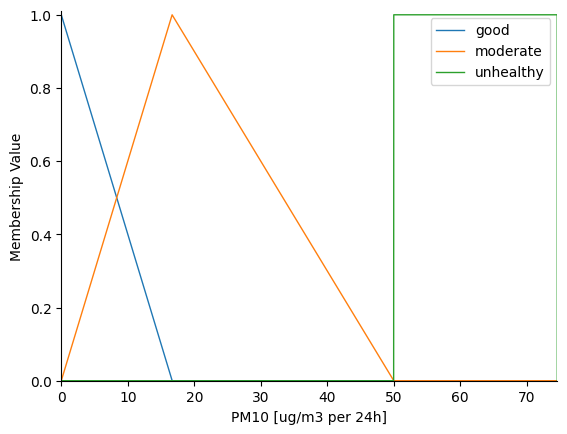

In [29]:
pm10[good] = fuzz.trimf(pm10.universe, [0, 0, pm10_safe_limit / 3])
pm10[moderate] = fuzz.trimf(pm10.universe, [0, pm10_safe_limit / 3, pm10_safe_limit])
pm10[unhealthy] = fuzz.trapmf(pm10.universe, [pm10_safe_limit, pm10_safe_limit, pm10_max, pm10_max])
pm10.view()

plt.xlabel("PM10 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

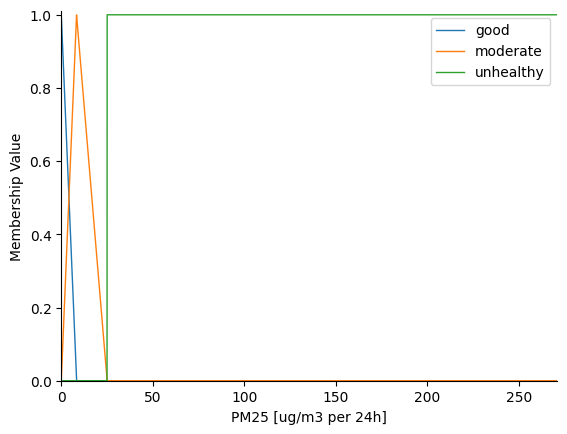

In [30]:
pm25[good] = fuzz.trimf(pm25.universe, [0, 0, pm25_safe_limit / 3])
pm25[moderate] = fuzz.trimf(pm25.universe, [0, pm25_safe_limit / 3, pm25_safe_limit])
pm25[unhealthy] = fuzz.trapmf(pm25.universe, [pm25_safe_limit, pm25_safe_limit, pm25_max, pm25_max])
pm25.view()

plt.xlabel("PM25 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

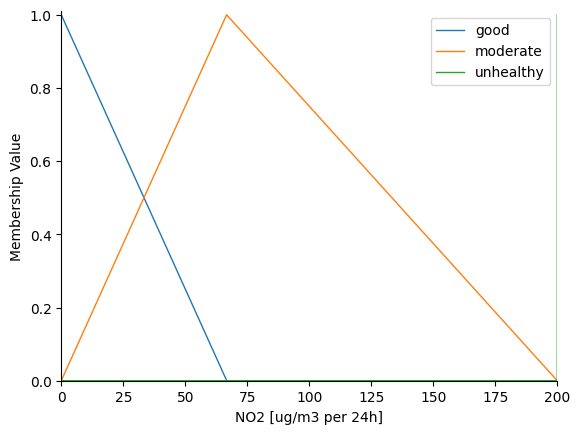

In [31]:
no2[good] = fuzz.trimf(no2.universe, [0, 0, no2_safe_limit / 3])
no2[moderate] = fuzz.trimf(no2.universe, [0, no2_safe_limit / 3, no2_safe_limit])
no2[unhealthy] = fuzz.trapmf(no2.universe, [no2_safe_limit, no2_safe_limit, no2_max, no2_max])
no2.view()

plt.xlabel("NO2 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

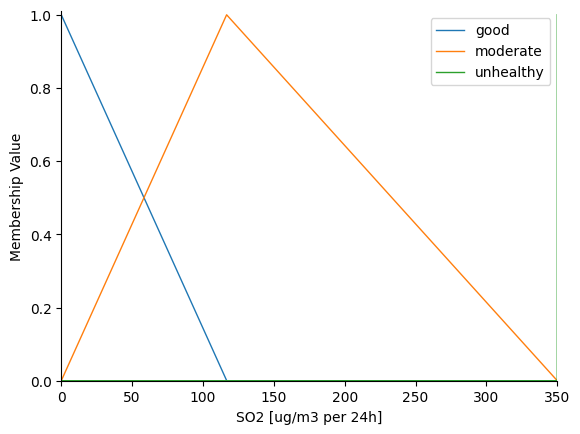

In [32]:
so2[good] = fuzz.trimf(so2.universe, [0, 0, so2_safe_limit / 3])
so2[moderate] = fuzz.trimf(so2.universe, [0, so2_safe_limit / 3, so2_safe_limit])
so2[unhealthy] = fuzz.trapmf(so2.universe, [so2_safe_limit, so2_safe_limit, so2_max, so2_max])
so2.view()

plt.xlabel("SO2 [ug/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

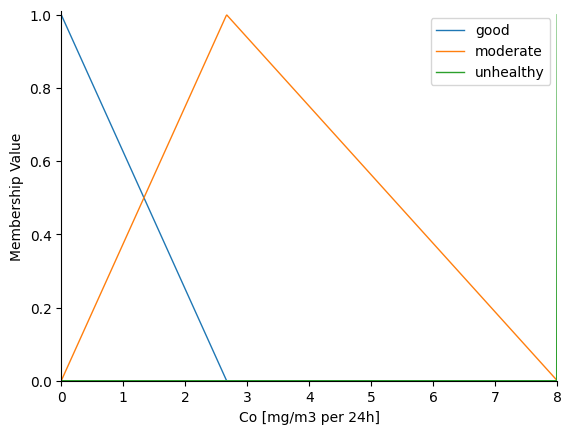

In [33]:
co[good] = fuzz.trimf(co.universe, [0, 0, co_safe_limit / 3])
co[moderate] = fuzz.trimf(co.universe, [0, co_safe_limit / 3, co_safe_limit])
co[unhealthy] = fuzz.trapmf(co.universe, [co_safe_limit, co_safe_limit, co_max, co_max])
co.view()

plt.xlabel("Co [mg/m3 per 24h]")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

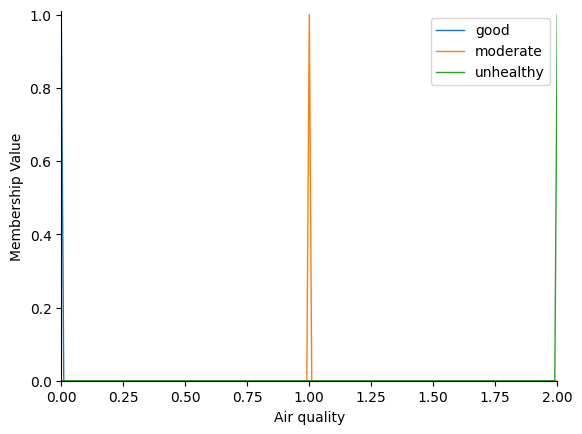

In [34]:
air_quality[good] = fuzz.trimf(air_quality.universe, [0, 0, 0])
air_quality[moderate] = fuzz.trimf(air_quality.universe, [1, 1, 1])
air_quality[unhealthy] = fuzz.trimf(air_quality.universe, [2, 2, 2])
air_quality.view()

plt.xlabel("Air quality")
plt.ylabel("Membership Value")
plt.legend()
plt.show()

In [35]:
rule1 = ctrl.Rule(pm10[unhealthy] | pm25[unhealthy] | no2[unhealthy] | so2[unhealthy] | co[unhealthy], air_quality[unhealthy])

#1
rule2 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[moderate] & so2[moderate] & co[moderate], air_quality[moderate]) # 1
rule3 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[moderate] & so2[moderate] & co[moderate], air_quality[moderate]) # 2
rule4 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[good] & so2[moderate] & co[moderate], air_quality[moderate]) # 3
rule5 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[moderate] & so2[good] & co[moderate], air_quality[moderate]) # 4
rule6 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[moderate] & so2[moderate] & co[good], air_quality[moderate]) # 5

#2
rule7 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[good] & so2[good] & co[good], air_quality[good]) # 1 - 2
rule8 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[moderate] & so2[good] & co[good], air_quality[good]) # 2 - 3
rule9 = ctrl.Rule(pm10[good] & pm25[good] & no2[moderate] & so2[moderate] & co[good], air_quality[good]) # 3 - 4
rule10 = ctrl.Rule(pm10[good] & pm25[good] & no2[good] & so2[moderate] & co[moderate], air_quality[good]) # 4 - 5

rule11 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[good] & so2[good] & co[moderate], air_quality[good]) # 1 - 5
rule12 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[moderate] & so2[good] & co[good], air_quality[good]) # 1 - 3
rule13 = ctrl.Rule(pm10[good] & pm25[good] & no2[moderate] & so2[good] & co[moderate], air_quality[good]) # 3 - 5
rule14 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[good] & so2[moderate] & co[good], air_quality[good]) # 2 - 4
rule15 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[good] & so2[moderate] & co[good], air_quality[good]) # 1 - 4
rule16 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[good] & so2[good] & co[moderate], air_quality[good]) # 2 - 5

###

#1
rule17 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[good] & so2[good] & co[good], air_quality[good]) # 1
rule18 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[good] & so2[good] & co[good], air_quality[good]) # 2
rule19 = ctrl.Rule(pm10[good] & pm25[good] & no2[moderate] & so2[good] & co[good], air_quality[good]) # 3
rule20 = ctrl.Rule(pm10[good] & pm25[good] & no2[good] & so2[moderate] & co[good], air_quality[good]) # 4
rule21 = ctrl.Rule(pm10[good] & pm25[good] & no2[good] & so2[good] & co[moderate], air_quality[good]) # 5

#2
rule22 = ctrl.Rule(pm10[good] & pm25[good] & no2[moderate] & so2[moderate] & co[moderate], air_quality[moderate]) # 1 - 2
rule23 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[good] & so2[moderate] & co[moderate], air_quality[moderate]) # 2 - 3
rule24 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[good] & so2[good] & co[moderate], air_quality[moderate]) # 3 - 4
rule25 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[moderate] & so2[good] & co[good], air_quality[moderate]) # 4 - 5

rule26 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[moderate] & so2[moderate] & co[good], air_quality[moderate]) # 1 - 5
rule27 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[good] & so2[moderate] & co[moderate], air_quality[moderate]) # 1 - 3
rule28 = ctrl.Rule(pm10[moderate] & pm25[moderate] & no2[good] & so2[moderate] & co[good], air_quality[moderate]) # 3 - 5
rule29 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[moderate] & so2[good] & co[moderate], air_quality[moderate]) # 2 - 4
rule30 = ctrl.Rule(pm10[good] & pm25[moderate] & no2[moderate] & so2[good] & co[moderate], air_quality[moderate]) # 1 - 4
rule31 = ctrl.Rule(pm10[moderate] & pm25[good] & no2[moderate] & so2[moderate] & co[good], air_quality[moderate]) # 2 - 5

rule32 = ctrl.Rule(pm10[good] & pm25[good] & no2[good] & so2[good] & co[good], air_quality[good])

all_rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10,
             rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, rule20,
             rule21, rule22, rule23, rule24, rule25, rule26, rule27, rule28, rule29, rule30,
             rule31, rule32]


In [36]:
air_quality_ctrl = ctrl.ControlSystem(all_rules)
air_quality_simulation = ctrl.ControlSystemSimulation(air_quality_ctrl)

In [37]:
for row in range(0, 32):
    air_quality_simulation.input["pm10"] = df.iloc[row, 1]
    air_quality_simulation.input["pm25"] = df.iloc[row, 2]
    air_quality_simulation.input["no2"] = df.iloc[row, 3]
    air_quality_simulation.input["so2"] = df.iloc[row, 4]
    air_quality_simulation.input["co"] = df.iloc[row, 5]
    air_quality_simulation.compute()
    print(round(air_quality_simulation.output["air_quality"]))

2
2
2
2
0
0
0
0
0
0
0
0
0
0
1
2
2
0
0
0
1
0
0
0
0
0
0
1
2
2
0
0


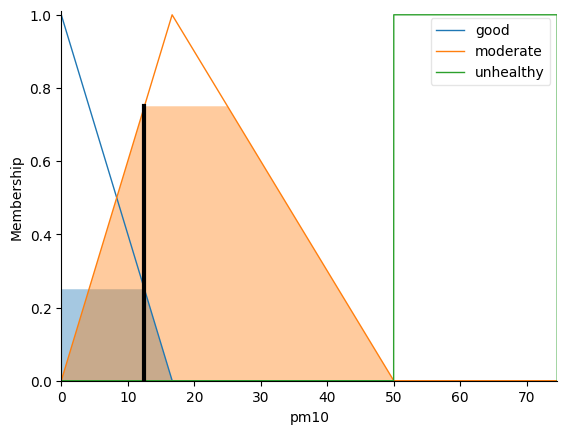

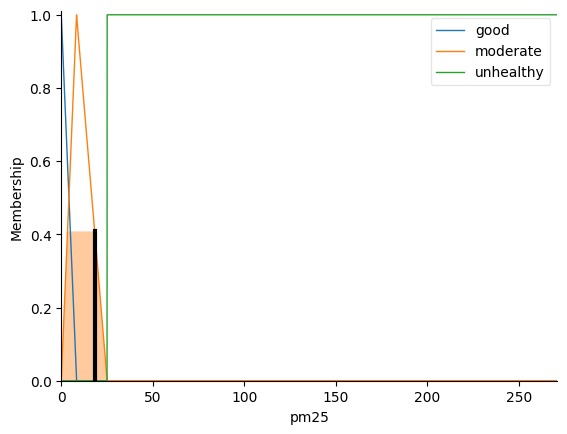

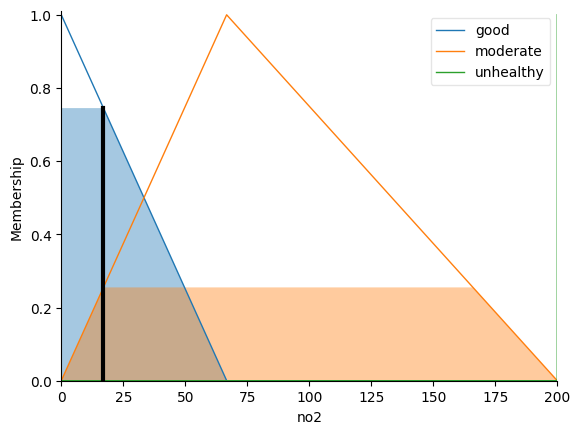

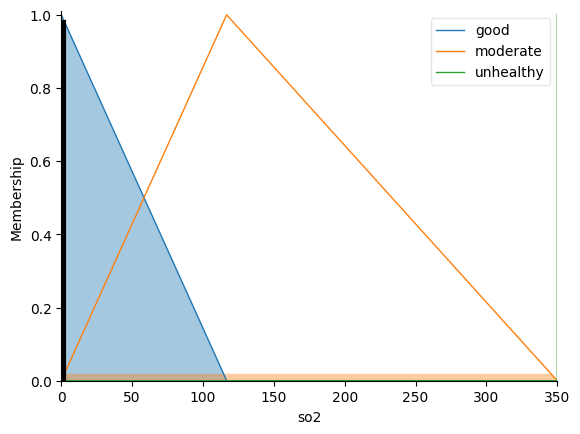

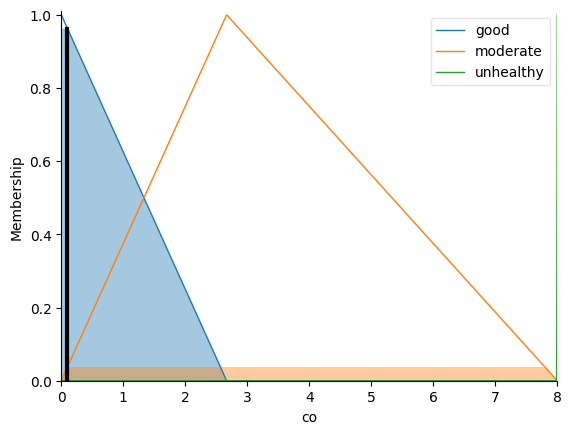

In [38]:
pm10.view(sim=air_quality_simulation)
pm25.view(sim=air_quality_simulation)
no2.view(sim=air_quality_simulation)
so2.view(sim=air_quality_simulation)
co.view(sim=air_quality_simulation)